# Test on Controllability and Robustness on Name Pair Task

In [285]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [286]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers

## Config

In [287]:
args = argparse.Namespace(
    batch_size=32, n_epochs=60, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=3, n_heads=4, d_model=128, dff=128*4)

In [288]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [289]:
# get data and vocab for the first 200 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data = f.read().splitlines()[:200]
    last_names = [x.split(' ')[-1] for x in data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:200]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple




# keep the same first name in ctx, sample different last names
test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names in ctx
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data[i]}' for i in range(len(data))]

test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[:5])
print(test_data_counterfactual_irrelevant_first_name_change[:5])
# modify original sentences to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data]


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]
test_tokenized_data_counterfactual_irrelevant_first_name_change = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))
integer_test_ids_counterfactual_irrelevant_first_name_change = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant_first_name_change)]
integer_test_ids_counterfactual_irrelevant_first_name_change = torch.tensor(np.array(integer_test_ids_counterfactual_irrelevant_first_name_change))

# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, 1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, 1:]
x_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, :-1]
y_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, 1:]

x_train, y_train, x_val, y_val, x_test, y_test = x[:100], y[:100], x[100:200], y[100:200], x[200:], y[200:]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
print(train_dataset)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)


test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant_first_name_change, y_test_counterfactual_irrelevant_first_name_change)

# take first 100 samples for testing
test_dataset_counterfactual = torch.utils.data.TensorDataset(*test_dataset_counterfactual[:100])
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant[:100])
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant_first_name_change[:100])

# dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
print("Number of batches: ", len(train_dl))
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]
print(len(test_dl_counterfactual), len(test_dl_counterfactual_irrelevant), len(test_dl_counterfactual_irrelevant_first_name_change))
for x, y in test_dl_counterfactual_irrelevant_first_name_change:
    print(x.shape, y.shape)
    break
    

vocab size:  404
['Aeriela has last name ROBITAILLE [SEP] Aaren has last name DURLAND', 'Adena has last name MANGANARO [SEP] Aarika has last name ROBITAILLE', 'Alvinia has last name BRICKETT [SEP] Abagael has last name SJOGREN', 'Alyss has last name WHITESEL [SEP] Abagail has last name MENGSTEAB', 'Adel has last name DOMPE [SEP] Abbe has last name OEHLENSCHLAGE']
['Aaren has last name CELLINI [SEP] Aaren has last name CELLINI', 'Aarika has last name JAINLETT [SEP] Aarika has last name JAINLETT', 'Abagael has last name STOTTLAR [SEP] Abagael has last name STOTTLAR', 'Abagail has last name CABEZAS [SEP] Abagail has last name CABEZAS', 'Abbe has last name LOISEL [SEP] Abbe has last name LOISEL']
['Alverta has last name DURLAND [SEP] Aaren has last name DURLAND', 'Adrianna has last name ROBITAILLE [SEP] Aarika has last name ROBITAILLE', 'Adoree has last name SJOGREN [SEP] Abagael has last name SJOGREN', 'Allie has last name MENGSTEAB [SEP] Abagail has last name MENGSTEAB', 'Abbie has last 


100%|██████████| 200/200 [00:00<00:00, 109540.45it/s]

100%|██████████| 200/200 [00:00<00:00, 105318.37it/s]

100%|██████████| 200/200 [00:00<00:00, 171546.18it/s]

100%|██████████| 200/200 [00:00<00:00, 331172.84it/s]

100%|██████████| 200/200 [00:00<00:00, 42390.26it/s]

100%|██████████| 200/200 [00:00<00:00, 35818.14it/s]

100%|██████████| 200/200 [00:00<00:00, 33178.85it/s]

100%|██████████| 200/200 [00:00<00:00, 59982.90it/s]

Number of batches:  4
4 4 4
torch.Size([32, 10]) torch.Size([32, 10])


## Model

In [290]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []        
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [291]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      51,712                 7.39%              True
│    │    └─Linear (weights): 3-1                                           52,116                 7.45%              True
│    └─Embedding (positional_embedder): 2-2                                 1,280                  0.18%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [292]:
lit_model = LitLanguageModel(model)

In [293]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 699 K 
----------------------------------------
699 K     Trainable params
0         Non-trainable params
699 K     Total params
2.800     Total estimated model params size (MB)


num decayed parameter tensors: 15, with 694,528 parameters
num non-decayed parameter tensors: 25, with 5,396 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The

Training: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [294]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])


def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=5):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name = input_seq.split(' ')[0]
        last_name = target_seq.split(' ')[-1]
        last_name_pred = predicted_seq.split(' ')[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name.capitalize())]
        trained_first_name = first_names[last_names.index(last_name.upper())]
        trained_last_name_pred = first_names[last_names.index(last_name_pred.upper())]
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name} has last name {trained_last_name.lower()}")
        print(f"{trained_first_name.lower()} has last name {last_name}")
        print(f"{trained_last_name_pred} has last name {last_name_pred.lower()} \n")

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


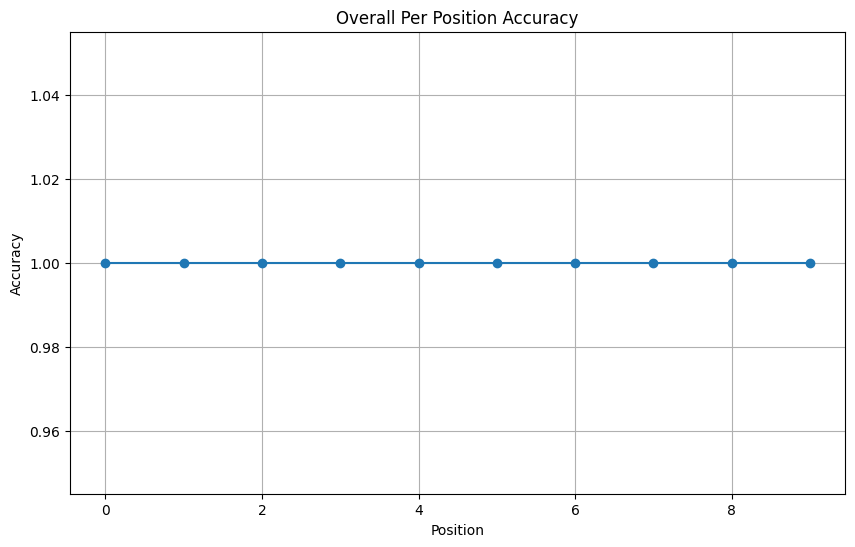

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │     0.0012865044409409165     │
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
│        test_perplexity        │      1.0012873411178589       │
└───────────────────────────────┴───────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

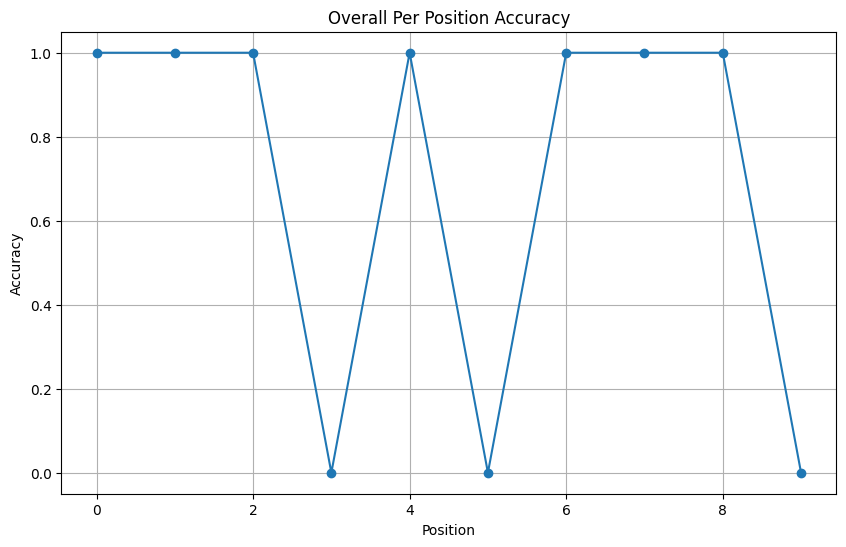

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      3.6044063568115234       │
│ test_overall_per_pos_acc_mean │       0.699999988079071       │
│     test_overall_seq_acc      │              0.0              │
│        test_perplexity        │       36.79096984863281       │
└───────────────────────────────┴───────────────────────────────┘

Input: alanah has last name peine [sep] alanah has last name
Predicted: has last name lauria [sep] adeline has last name kojima
Target: has last name peine [sep] alanah has last name peine
Pretrained Knowledge:
alanah has last name peine
alanah has last name peine
Adena has last name kojima 

Input: alane has last name foesch [sep] alane has last name
Predicted: has last name yafai [sep] aile has last name yafai
Target: has last name foesch [sep] alane has last name foesch
Pretrained Knowledge:
alane has last name foesch
alane has last name foesch
Addi has last name yafai 

Input: alanna has last name bland [sep] alanna has last name
Predicted: has last name grames [sep] ailsun has last name grames
Target: has last name bland [sep] alanna has last name bland
Pretrained Knowledge:
alanna has last name bland
alanna has last name bland
Aila has last name grames 

Input: alayne has last name dhondt [sep] alayne has last name
Predicted: has last name durland [sep] adelind has last name slou

In [295]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}


# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
# model performance on the validation set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=val_dl)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

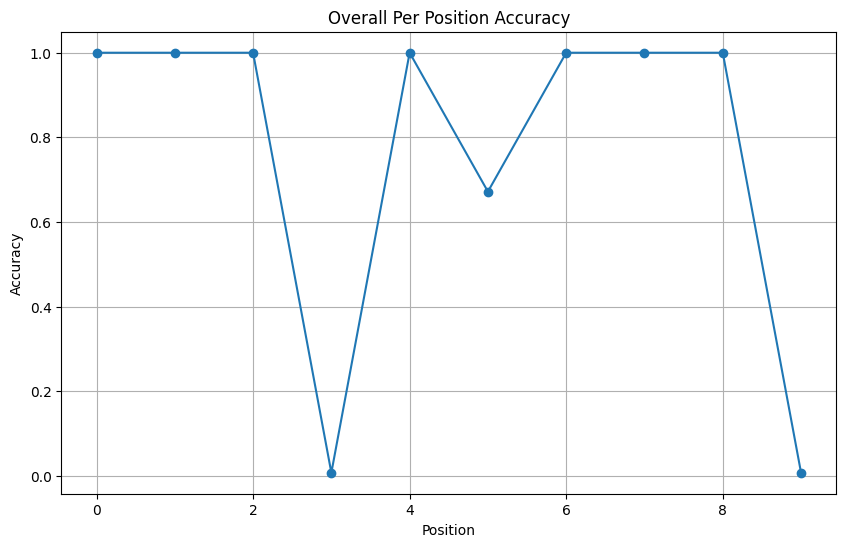

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      3.3277382850646973       │
│ test_overall_per_pos_acc_mean │       0.768750011920929       │
│     test_overall_seq_acc      │           0.0078125           │
│        test_perplexity        │      28.653148651123047       │
└───────────────────────────────┴───────────────────────────────┘

Input: aaren has last name cellini [sep] aaren has last name
Predicted: has last name durland [sep] ailee has last name durland
Target: has last name cellini [sep] aaren has last name cellini
Pretrained Knowledge:
aaren has last name durland
allina has last name cellini
Aaren has last name durland 

Input: aarika has last name jainlett [sep] aarika has last name
Predicted: has last name robitaille [sep] aarika has last name robitaille
Target: has last name jainlett [sep] aarika has last name jainlett
Pretrained Knowledge:
aarika has last name robitaille
alexandrina has last name jainlett
Aarika has last name robitaille 

Input: abagael has last name stottlar [sep] abagael has last name
Predicted: has last name sjogren [sep] abagael has last name sjogren
Target: has last name stottlar [sep] abagael has last name stottlar
Pretrained Knowledge:
abagael has last name sjogren
ailee has last name stottlar
Abagael has last name sjogren 

Input: abagail has last name cabezas [sep] abagail has 

In [296]:
lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

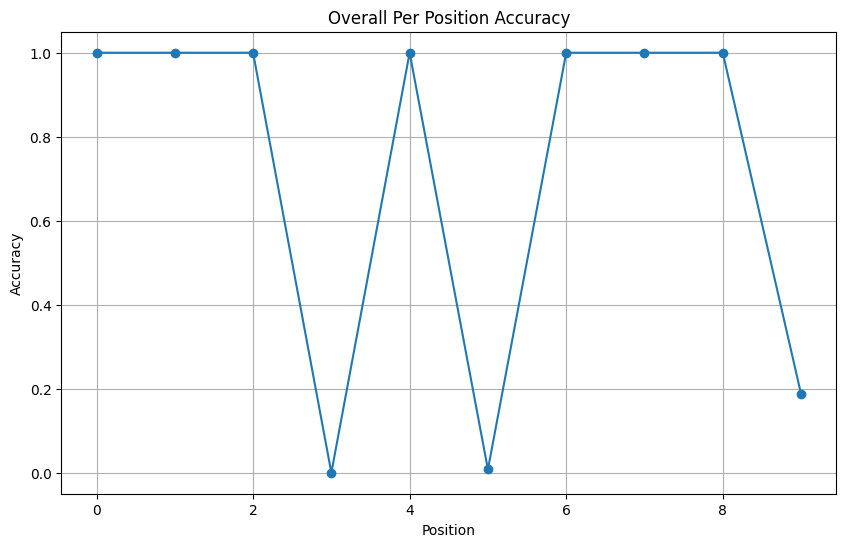

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      2.7267470359802246       │
│ test_overall_per_pos_acc_mean │       0.719531238079071       │
│     test_overall_seq_acc      │              0.0              │
│        test_perplexity        │      15.334587097167969       │
└───────────────────────────────┴───────────────────────────────┘

Input: aeriela has last name robitaille [sep] aaren has last name
Predicted: has last name baham [sep] aila has last name baham
Target: has last name robitaille [sep] aaren has last name durland
Pretrained Knowledge:
aeriela has last name baham
robitaille has first name aarika
aila has last name grames
Aeriela has last name baham 

Input: adena has last name manganaro [sep] aarika has last name
Predicted: has last name kojima [sep] afton has last name kojima
Target: has last name manganaro [sep] aarika has last name robitaille
Pretrained Knowledge:
adena has last name kojima
manganaro has first name allianora
afton has last name pittenger
Adena has last name kojima 

Input: alvinia has last name brickett [sep] abagael has last name
Predicted: has last name sjogren [sep] ag has last name sjogren
Target: has last name brickett [sep] abagael has last name sjogren
Pretrained Knowledge:
alvinia has last name sollis
brickett has first name alessandra
ag has last name polacco
Abagael has last

In [297]:

def mismatch_seq_print_irrelevant(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        last_name_pred = predicted_seq.split(" ")[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        trained_last_name_pred = first_names[last_names.index(last_name_pred.upper())]

        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()}")        
        print(f"{trained_last_name_pred} has last name {last_name_pred.lower()} \n")


# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print_irrelevant(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [298]:
test_data_empty_ctx = [' [SEP] ' + sentence.split(" [SEP] ")[-1] for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))



# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = torch.utils.data.TensorDataset(*test_dataset_empty_ctx[:100])
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name DURLAND', ' [SEP] Aarika has last name ROBITAILLE', ' [SEP] Abagael has last name SJOGREN', ' [SEP] Abagail has last name MENGSTEAB', ' [SEP] Abbe has last name OEHLENSCHLAGE']



100%|██████████| 200/200 [00:00<00:00, 863025.51it/s]

100%|██████████| 200/200 [00:00<00:00, 77932.07it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

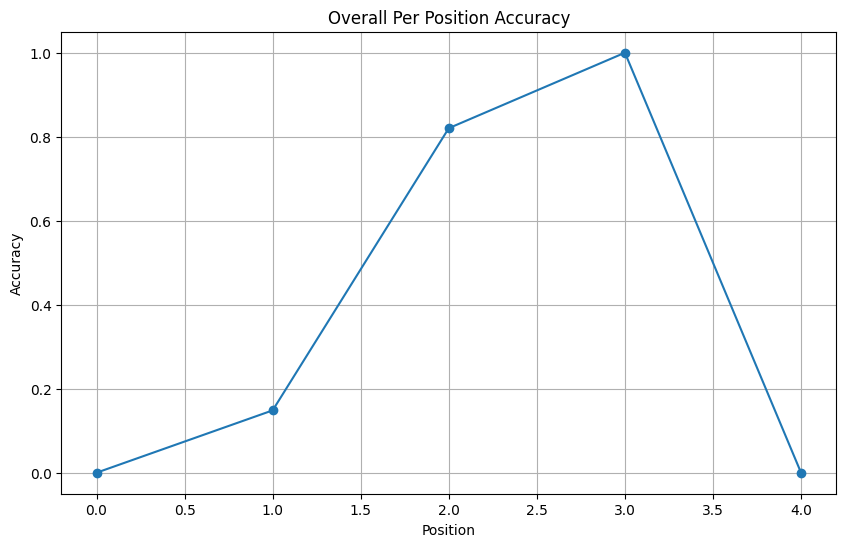

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │       7.665136814117432       │
│ test_overall_per_pos_acc_mean │      0.39375001192092896      │
│     test_overall_seq_acc      │              0.0              │
│        test_perplexity        │       2150.00244140625        │
└───────────────────────────────┴───────────────────────────────┘

Input: [sep] aaren has last name
Predicted: has name last name [sep]
Target: aaren has last name durland
Input: [sep] aarika has last name
Predicted: has name last name [sep]
Target: aarika has last name robitaille
Input: [sep] abagael has last name
Predicted: has name last name [sep]
Target: abagael has last name sjogren
Input: [sep] abagail has last name
Predicted: has last last name [sep]
Target: abagail has last name mengsteab
Input: [sep] abbe has last name
Predicted: has snover last name [sep]
Target: abbe has last name oehlenschlage


In [299]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map, max_examples=5):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

In [300]:
def mismatch_seq_print_irrelevant_first_name(mismatch, reverse_vocab_map, max_examples=5):
    
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


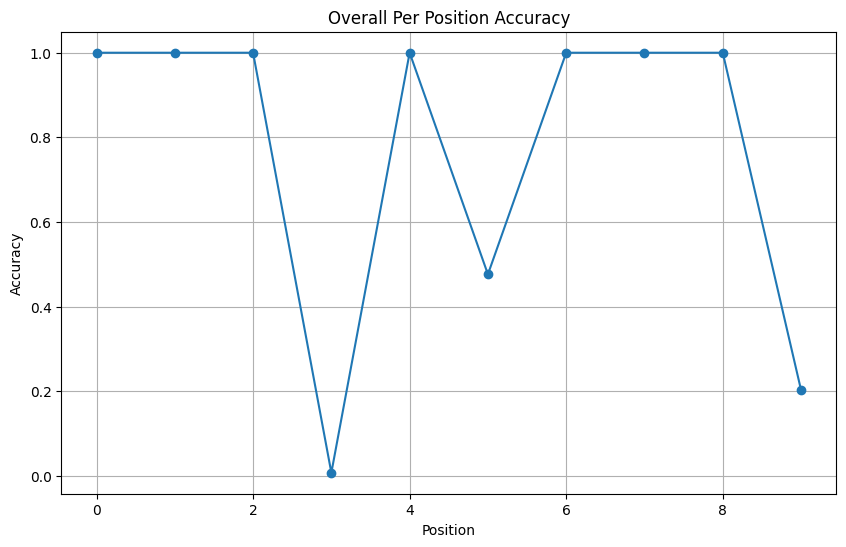

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │       1.857226848602295       │
│ test_overall_per_pos_acc_mean │       0.768750011920929       │
│     test_overall_seq_acc      │           0.0078125           │
│        test_perplexity        │       6.470306873321533       │
└───────────────────────────────┴───────────────────────────────┘

Input: alverta has last name durland [sep] aaren has last name
Predicted: has last name gabossi [sep] aaren has last name durland
Target: has last name durland [sep] aaren has last name durland
Pretrained Knowledge:
alverta has last name wehunt
durland has first name aaren
aaren has last name durland 

Input: adrianna has last name robitaille [sep] aarika has last name
Predicted: has last name holabaugh [sep] adrianna has last name holabaugh
Target: has last name robitaille [sep] aarika has last name robitaille
Pretrained Knowledge:
adrianna has last name holabaugh
robitaille has first name aarika
adrianna has last name holabaugh 

Input: adoree has last name sjogren [sep] abagael has last name
Predicted: has last name lauria [sep] adoree has last name lauria
Target: has last name sjogren [sep] abagael has last name sjogren
Pretrained Knowledge:
adoree has last name lauria
sjogren has first name abagael
adoree has last name lauria 

Input: allie has last name mengsteab [sep] abagail ha

In [302]:

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant_first_name_change)
mismatch_seq_print_irrelevant_first_name(lit_model.mismatched_sequences, reverse_vocab_map)